<a href="https://colab.research.google.com/github/Shirui-peng/Deep-Learning-in-Quantitative-Trading/blob/main/Chapter2/03_vol_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Volatility clustering is an extensively observed phenomenon in financial markets, characterized by sequences of high volatility periods that are succeeded by similarly high volatility periods, and periods of low volatility that are followed by similarly low volatility periods. We have shown that financial returns do not have constant variance. Now, let us look at ARCH and GARCH models that predict volatility.

In [2]:
!pip install arch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 6.8 MB/s eta 0:00:00


In [3]:
# let us simulate some return data that uses a varying volatility
np.random.seed(42)

omega = 0.1
alpha = 0.05
beta  = 0.90
T = 1000

sigma2 = np.zeros(T)
rets   = np.zeros(T)

sigma2[0] = omega / (1 - alpha - beta)  # Theoretical long-run variance if alpha+beta < 1

for t in range(1, T):
    sigma2[t] = omega + alpha * rets[t-1]**2 + beta * sigma2[t-1]
    rets[t]   = np.random.randn() * np.sqrt(sigma2[t])

dates = pd.date_range(start='2020-01-01', periods=T, freq='D')
df = pd.DataFrame({'returns': rets}, index=dates)

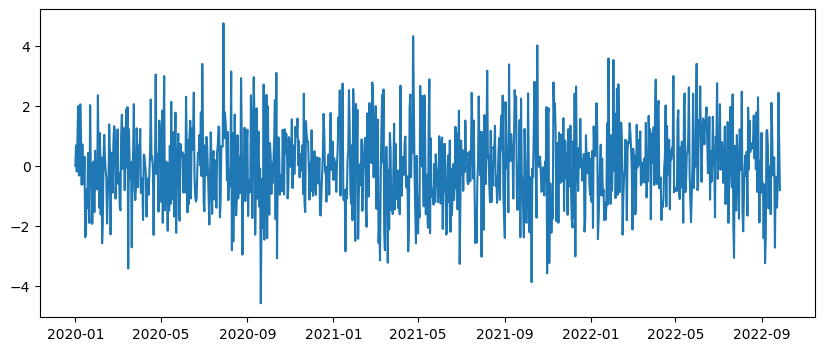

In [4]:
plt.figure(figsize=(10,4))
plt.plot(df['returns'])

In [5]:
# ARCH(1) model
arch_model_1 = arch_model(df['returns'], p=1, o=0, q=0, dist='normal')
res_arch_1 = arch_model_1.fit(disp='off')
print("ARCH(1) Model Summary:\n", res_arch_1.summary())

# this is essentially the in-sample results
fitted_arch_vol = res_arch_1.conditional_volatility

# Let's forecast 10 steps ahead
n_forecast = 10
arch_forecasts = res_arch_1.forecast(horizon=n_forecast, reindex=False)
# This returns a ForecastResult object; we can extract mean/variance
arch_vol_forecast = arch_forecasts.variance.values[-1, :]  # Last row, all horizons

ARCH(1) Model Summary:
                       Constant Mean - ARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1712.68
Distribution:                  Normal   AIC:                           3431.36
Method:            Maximum Likelihood   BIC:                           3446.08
                                        No. Observations:                 1000
Date:                Thu, Sep 11 2025   Df Residuals:                      999
Time:                        20:09:15   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0199  4.234e-02     

In [6]:
# GARCH(1,1) model
garch_model_11 = arch_model(df['returns'], p=1, o=0, q=1, dist='normal')
res_garch_11 = garch_model_11.fit(disp='off')
print("\nGARCH(1,1) Model Summary:\n", res_garch_11.summary())

# In-sample (fitted) conditional volatility
fitted_garch_vol = res_garch_11.conditional_volatility

# Forecast 10 steps ahead
n_forecast = 10
garch_forecasts = res_garch_11.forecast(horizon=n_forecast, reindex=False)
garch_vol_forecast = garch_forecasts.variance.values[-1, :]  # Last row


GARCH(1,1) Model Summary:
                      Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1709.53
Distribution:                  Normal   AIC:                           3427.06
Method:            Maximum Likelihood   BIC:                           3446.69
                                        No. Observations:                 1000
Date:                Thu, Sep 11 2025   Df Residuals:                      999
Time:                        20:10:17   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0269  4.197e-02 

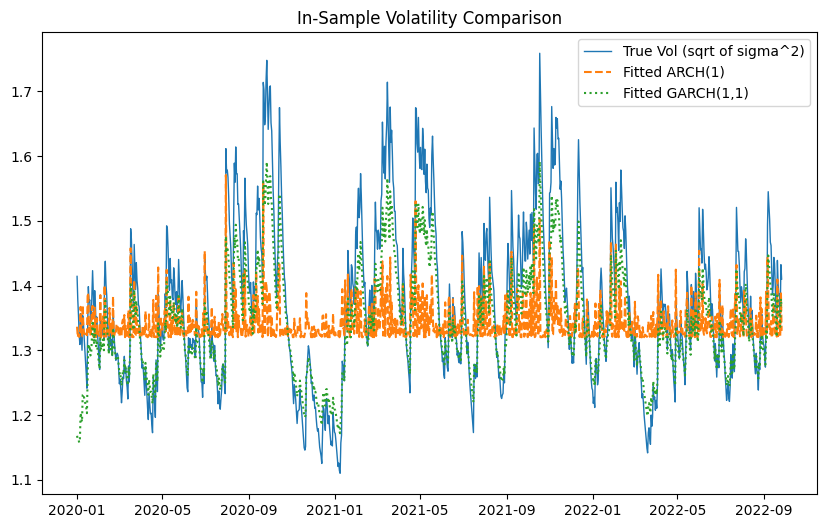

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, np.sqrt(sigma2), label='True Vol (sqrt of sigma^2)', linewidth=1)
plt.plot(df.index, fitted_arch_vol, label='Fitted ARCH(1)', linestyle='--')
plt.plot(df.index, fitted_garch_vol, label='Fitted GARCH(1,1)', linestyle=':')
plt.title('In-Sample Volatility Comparison')
plt.legend()
plt.show()

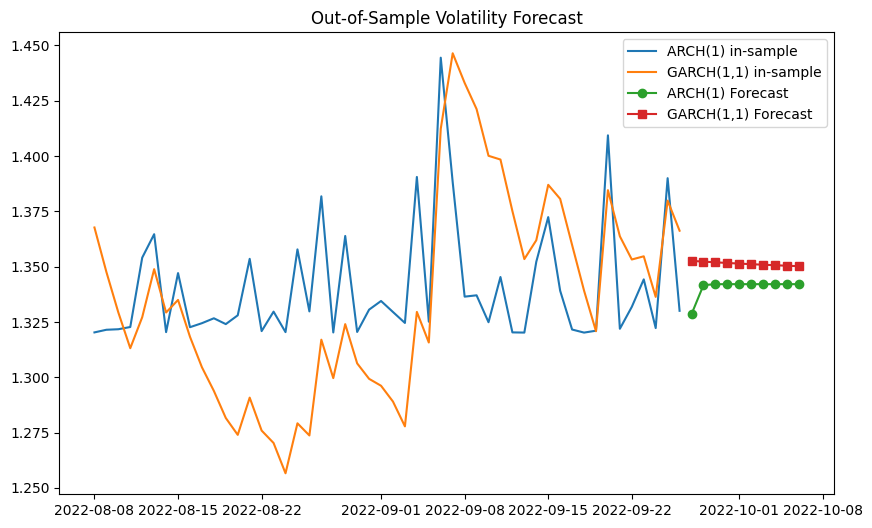

In [8]:
last_n = 50  # Show the last 50 in-sample points for context
df_plot = df.iloc[-last_n:].copy()

# Extend the index for forecast horizon
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='D')
df_forecast = pd.DataFrame(index=future_dates)

# Store forecasted vol (this is variance -> take sqrt for volatility)
df_forecast['ARCH_vol_forecast'] = np.sqrt(arch_vol_forecast)
df_forecast['GARCH_vol_forecast'] = np.sqrt(garch_vol_forecast)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, fitted_arch_vol[-last_n:], label='ARCH(1) in-sample')
plt.plot(df_plot.index, fitted_garch_vol[-last_n:], label='GARCH(1,1) in-sample')
plt.plot(df_forecast.index, df_forecast['ARCH_vol_forecast'], label='ARCH(1) Forecast', marker='o')
plt.plot(df_forecast.index, df_forecast['GARCH_vol_forecast'], label='GARCH(1,1) Forecast', marker='s')
plt.title('Out-of-Sample Volatility Forecast')
plt.legend()
plt.show()